In [8]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import talib as ta

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [9]:

# 1. 读取数据
df = pd.read_csv('data/spot/binance/15m/BTC_USDT.csv')

# 选择时间范围
START_DATE = '2023-06-01'
END_DATE = '2025-06-30'
# 确保时间列为datetime类型
df['datetime'] = pd.to_datetime(df['datetime'])
data = df[(df['datetime'] >= START_DATE) & (df['datetime'] <= END_DATE)]

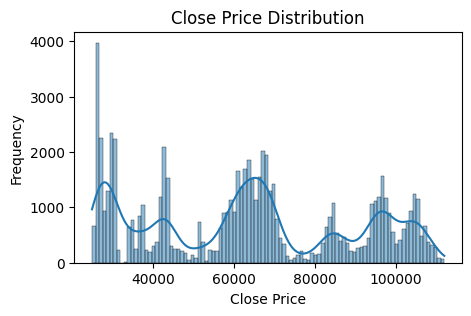

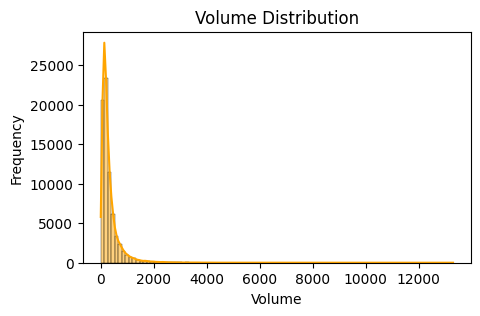

                open           high            low          close  \
count   72961.000000   72961.000000   72961.000000   72961.000000   
mean    63331.129743   63435.674913   63223.563573   63332.241442   
std     25915.526686   25961.765073   25868.985485   25915.720301   
min     24893.100000   24926.790000   24800.000000   24893.090000   
25%     40661.810000   40779.660000   40532.170000   40679.970000   
50%     63464.770000   63582.000000   63343.470000   63465.410000   
75%     85502.030000   85690.020000   85329.270000   85502.170000   
max    111898.740000  111980.000000  111681.810000  111898.740000   

             volume  
count  72961.000000  
mean     340.541351  
std      427.859641  
min        3.985380  
25%      126.941280  
50%      216.317980  
75%      391.761020  
max    13289.889260  


,datetime,open,high,low,close,volume
count,72961,72961.000000,72961.000000,72961.000000,72961.000000,72961.000000
mean,2024-06-15 00:00:00,63331.129743,63435.674913,63223.563573,63332.241442,340.541351
min,2023-06-01 00:00:00,24893.100000,24926.790000,24800.000000,24893.090000,3.985380
25%,2023-12-08 00:00:00,40661.810000,40779.660000,40532.170000,40679.970000,126.941280
50%,2024-06-15 00:00:00,63464.770000,63582.000000,63343.470000,63465.410000,216.317980
75%,2024-12-22 00:00:00,85502.030000,85690.020000,85329.270000,85502.170000,391.761020
max,2025-06-30 00:00:00,111898.740000,111980.000000,111681.810000,111898.740000,13289.889260
std,NaN,25915.526686,25961.765073,25868.985485,25915.720301,427.859641


In [10]:

# 2. 数据预处理，做一些初步的数据统计分布描述

# 绘制价格分布直方图
plt.figure(figsize=(5, 3))
sns.histplot(data['close'], bins=100, kde=True)
plt.title('Close Price Distribution')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

# 绘制成交量分布直方图
plt.figure(figsize=(5, 3))
sns.histplot(data['volume'], bins=100, kde=True, color='orange')
plt.title('Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

# 计算并显示主要数值特征的描述性统计
print(data[['open', 'high', 'low', 'close', 'volume']].describe())
data.describe()


In [11]:

# 2. 特征工程（示例：用常见技术指标）
"""
技术指标列表
趋势: EMA (20, 60, 100, 200), MACD (12,26,9; 5,35,5), ADX (14)
动量: RSI (10, 20, 60), %K Stochastic (10, 30, 200)
反转: ROC(RSI) (10, 20, 50)
振幅: ATR (20, 60, 100), Bollinger Bands (20, 2)
成交量: OBV, VWAP
短期动态: MOM (10, 30, 50), PROC (10, 50)
"""

# 用talib计算特征，全部用talib函数

# 用talib计算特征，全部用talib函数
data['ema_20'] = ta.EMA(data['close'], timeperiod=20)
data['ema_60'] = ta.EMA(data['close'], timeperiod=60)
data['ema_100'] = ta.EMA(data['close'], timeperiod=100)
data['ema_200'] = ta.EMA(data['close'], timeperiod=200)

macd_20_60, macdsignal_20_60, macdhist_20_60 = ta.MACD(data['close'], fastperiod=20, slowperiod=60, signalperiod=9)
macd_10_20, macdsignal_10_20, macdhist_10_20 = ta.MACD(data['close'], fastperiod=10, slowperiod=20, signalperiod=5)
data['macd_20_60'] = macd_20_60
data['macd_10_20'] = macd_10_20

data['adx_10'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=10)
data['adx_20'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=20)
data['adx_60'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=60)

data['rsi_7'] = ta.RSI(data['close'], timeperiod=7)
data['rsi_20'] = ta.RSI(data['close'], timeperiod=20)
data['rsi_60'] = ta.RSI(data['close'], timeperiod=60)

slowk_10, slowd_10 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=10, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
slowk_30, slowd_30 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=30, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
slowk_100, slowd_100 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=100, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
data['stoch_k_10'] = slowk_10
data['stoch_k_30'] = slowk_30
data['stoch_k_100'] = slowk_100

data['roc_rsi_10'] = ta.ROC(data['rsi_7'], timeperiod=10)
data['roc_rsi_20'] = ta.ROC(data['rsi_7'], timeperiod=20)
data['roc_rsi_50'] = ta.ROC(data['rsi_7'], timeperiod=50)

data['atr_20'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=20)
data['atr_60'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=60)
data['atr_100'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=100)

# talib没有直接的Bollinger带宽和百分比，需手动计算
upper, middle, lower = ta.BBANDS(data['close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
data['bb_width'] = upper - lower
data['bb_percent'] = (data['close'] - lower) / (upper - lower)

data['obv'] = ta.OBV(data['close'], data['volume'])

# VWAP简单实现
data['vwap'] = (data['volume'] * (data['high'] + data['low'] + data['close']) / 3).cumsum() / data['volume'].cumsum()

data['mom_5'] = ta.MOM(data['close'], timeperiod=5)
data['mom_20'] = ta.MOM(data['close'], timeperiod=20)
data['mom_50'] = ta.MOM(data['close'], timeperiod=50)

data['proc_5'] = ta.ROC(data['close'], timeperiod=5)
data['proc_20'] = ta.ROC(data['close'], timeperiod=20)

data['vol_ma_20'] = data['volume'].rolling(window=20).mean()
data['vol_ma_60'] = data['volume'].rolling(window=60).mean()

C:\Users\hp\AppData\Local\Temp\ipykernel_7464\1518125282.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ema_20'] = ta.EMA(data['close'], timeperiod=20)
C:\Users\hp\AppData\Local\Temp\ipykernel_7464\1518125282.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ema_60'] = ta.EMA(data['close'], timeperiod=60)
C:\Users\hp\AppData\Local\Temp\ipykernel_7464\1518125282.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [ ]:
TARGET_PERIOD = 5
# T-1 到 T+4 的涨跌为目标
data['target'] = np.sign(data['close'].shift(-TARGET_PERIOD) / data['close'])

# 删除含有NaN值的行
data.dropna(inplace=True)  

C:\Users\hp\AppData\Local\Temp\ipykernel_7464\113742678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['close'].shift(-TARGET_PERIOD) / data['close'] - 1
C:\Users\hp\AppData\Local\Temp\ipykernel_7464\113742678.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [13]:


# 划分特征和目标
feature_cols = [col for col in data.columns if col not in ['datetime', 'target']]
X = data[feature_cols]
y = data['target']

    # 划分训练集和验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, shuffle=False)

# 正则归一化（标准化）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [14]:
X_train.shape

(58205, 37)

In [20]:
# 训练 LightGBM 回归模型
lgb_train = lgb.Dataset(X_train_scaled, y_train)
lgb_val = lgb.Dataset(X_val_scaled, y_val)
lgb_test = lgb.Dataset(X_test_scaled, y_test)

params = {
    'num_leaves': 38,
    'min_data_in_leaf': 50,
    'objective': 'regression',
    'max_depth': -1,
    'learning_rate': 0.01,
    "min_sum_hessian_in_leaf": 6,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.7,
    "bagging_seed": 11,
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    'metric': 'mse',
    "random_state": 2019,
    # 'device': 'gpu'
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=200,
    valid_sets=[lgb_train, lgb_val],
)

# 预测
y_pred_test = gbm.predict(X_test_scaled, num_iteration=gbm.best_iteration)

# 评估

# 回归问题的“准确率”通常指预测方向的准确率（涨跌判断）
# 这里以 y_pred 和 y_test 同号为“方向预测正确”
direction_acc = np.mean((y_pred_test > 0) == (y_test > 0))
print(f"Direction Accuracy: {direction_acc:.4f}")


mae = mean_absolute_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
r2 = r2_score(y_test, y_pred_test)

print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R2: {r2:.4f}")

Direction Accuracy: 0.5376
MAE: 0.002603
RMSE: 0.003879
R2: 0.0169


In [22]:
y_pred_test

array([ 0.0001999 ,  0.00021085,  0.00022346, ..., -0.00016247,
       -0.00015988, -0.00015965])

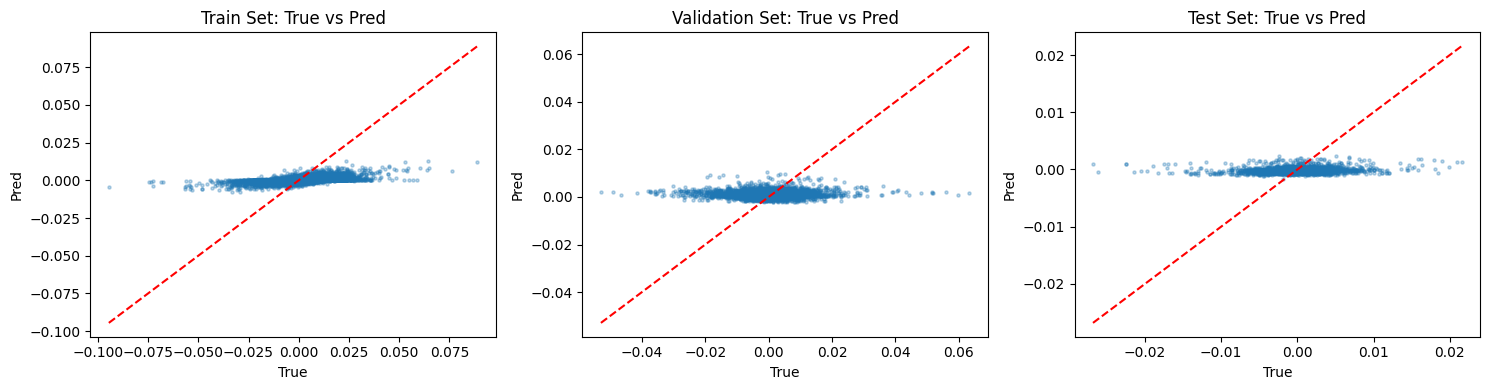

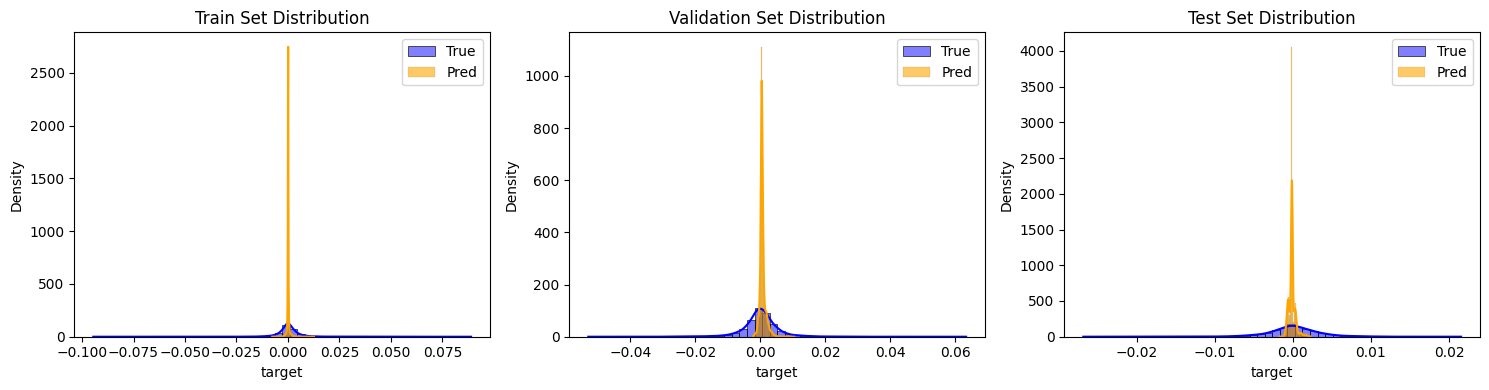

In [21]:
# 训练集预测
y_train_pred = gbm.predict(X_train_scaled, num_iteration=gbm.best_iteration)
# 验证集预测
y_val_pred = gbm.predict(X_val_scaled, num_iteration=gbm.best_iteration)

# 1. 真实值 vs 预测值散点图
plt.figure(figsize=(15, 4))
for i, (y_true, y_pred, title) in enumerate([
    (y_train, y_train_pred, 'Train'),
    (y_val, y_val_pred, 'Validation'),
    (y_test, y_pred_test, 'Test')
]):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_true, y_pred, alpha=0.3, s=5)
    plt.xlabel('True')
    plt.ylabel('Pred')
    plt.title(f'{title} Set: True vs Pred')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')

plt.tight_layout()
plt.show()

# 2. 预测值和真实值分布直方图
plt.figure(figsize=(15, 4))
for i, (y_true, y_pred, title) in enumerate([
    (y_train, y_train_pred, 'Train'),
    (y_val, y_val_pred, 'Validation'),
    (y_test, y_pred_test, 'Test')
]):
    plt.subplot(1, 3, i+1)
    sns.histplot(y_true, color='blue', label='True', kde=True, stat='density', bins=50)
    sns.histplot(y_pred, color='orange', label='Pred', kde=True, stat='density', bins=50, alpha=0.6)
    plt.title(f'{title} Set Distribution')
    plt.legend()

plt.tight_layout()
plt.show()